## Todo

- comparar leitos cnes com leitos api, ver se está muito fora
- medidas de desatualização por estado e tipo de gestão

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timezone, timedelta
import time
import glob
import gzip
import requests
import seaborn as sns
import matplotlib

In [2]:
# matplotlib.font_manager._rebuild()
# from matplotlib.font_manager import findfont, FontProperties
# font = findfont(FontProperties(family=['IBM Plex Sans']))
# font

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

# this sets the python locale to pt_BR.UTF-8
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

OK_COLOR_SCALE_DIVERGING_COLORS = ['#00cb8d', '#99d9b1', '#eae4d6', '#e48fb0', '#d01c8c']
OK_COLOR_SCALE_DIVERGING = matplotlib.colors.LinearSegmentedColormap.from_list("", OK_COLOR_SCALE_DIVERGING_COLORS)

font_family = {'family':'IBM Plex Sans', 
               'weight': 'regular'
              }

factor = 1
SMALL_SIZE = 14 * factor
MEDIUM_SIZE = 20 * factor
BIGGER_SIZE = 24 * factor

plt.rc('font', size=SMALL_SIZE, **font_family)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def increase_chart_margins(plt, plot_margin=0.15):
    x0, x1, y0, y1 = plt.axis()
    plt.axis((x0 - plot_margin,
              x1 + plot_margin,
              y0 - plot_margin,
              y1 + plot_margin))

def remove_chart_spines(ax, spines=['top', 'right', 'bottom', 'left']):
    for spine in spines:
        ax.spines[spine].set_visible(False)


def set_ticks(ax):
    ax.tick_params(axis='both', which='major', labelsize=SMALL_SIZE)
    ax.tick_params(axis='both', which='minor', labelsize=SMALL_SIZE)


def set_grid(ax):
    ax.xaxis.grid(True, which='minor', linestyle='-', linewidth=0)
    ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.6)
    ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.6)


def set_axis(ax):
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x).replace('.', ',')))
    ax.xaxis.label.set_visible(True)


def default_chart_configs(ax):
    increase_chart_margins(plt)
    remove_chart_spines(ax)
    set_ticks(ax)
    set_grid(ax)
    set_axis(ax)

In [10]:
# # dt_run = datetime.datetime.strptime('2021-02-18', '%Y-%m-%d')
# dt_run = datetime.now(timezone.utc) # UTC time
# print(dt_run)

## Ler dados

In [11]:
DATA_FOLDER = 'data/leitos/'

In [12]:
# data_files = glob.glob(f'{DATA_FOLDER}data_*.json.gz')
data_files = glob.glob(f'{DATA_FOLDER}data_*.csv.gz')
data_files.sort(reverse=True)
DATA_FILE = data_files[0]
print(DATA_FILE)

data/leitos/data_2021-03-09.csv.gz


In [13]:
# with gzip.open(DATA_FILE, 'r') as fin:
#     data = json.loads(fin.read().decode('utf-8'))
    
#     hits = data['hits']['hits']
#     df = pd.json_normalize(hits)

#     print(df.columns.values)
#     df.columns = [x.replace('_source.', '') for x in df.columns.values]

#     df.head()

In [14]:
# TS_RUN = pd.to_datetime(data['ts_run'])

In [15]:
df = pd.read_csv(DATA_FILE)

In [16]:
TS_RUN = pd.to_datetime(df.iloc[0]['ts_run'])

In [17]:
df.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run'],
      dtype=object)

## Limpar e criar features

In [18]:
df = df.fillna({
    'ofertaHospCli': 0,
    'ofertaSRAGCli': 0,
    'ofertaHospUti': 0,
    'ofertaSRAGUti': 0,
    'ocupHospCli': 0,
    'ocupSRAGCli': 0,
    'ocupHospUti': 0,
    'ocupSRAGUti': 0,
})

### Considerando oferta sem ocupação

In [19]:
df['totalOfertaCli'] = df['ofertaHospCli'] + df['ofertaSRAGCli']
df['totalOfertaUti'] = df['ofertaHospUti'] + df['ofertaSRAGUti']
df['totalOcupCli'] = df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOcupUti'] = df['ocupHospUti'] + df['ocupSRAGUti']

### Considerando oferta como oferta + ocupação

In [20]:
df['totalOfertaCliAlt'] = df['ofertaHospCli'] + df['ofertaSRAGCli'] + df['ocupHospCli'] + df['ocupSRAGCli']
df['totalOfertaUtiAlt'] = df['ofertaHospUti'] + df['ofertaSRAGUti'] + df['ocupHospUti'] + df['ocupSRAGUti']

### Tem UTI

- Tem alguma vaga ou ocupação de UTI, Hosp ou SRAG

In [21]:
df['has_uti_proxy'] = np.where(df['totalOfertaUtiAlt'] > 0, True, False)

### Colunas de tempo

In [22]:
df['dataNotificacaoOcupacao'] = pd.to_datetime(df['dataNotificacaoOcupacao'])

In [23]:
UPDATED_DAYS = [7, 14, 90]
for d in UPDATED_DAYS:
    df[f'updated_{str(d)}d'] = np.where(df['dataNotificacaoOcupacao'] >= TS_RUN - timedelta(days=d), True, False)

In [24]:
for d in UPDATED_DAYS:
    pct_outdated = len(df[df[f'updated_{str(d)}d'] == True]) / len(df)
    print(f'{round(pct_outdated * 100, 1)}% updated in {str(d)} days')

64.6% updated in 7 days
66.8% updated in 14 days
75.0% updated in 90 days


In [25]:
df[df['updated_90d'] == False].head()

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,totalOfertaCli,totalOfertaUti,totalOcupCli,totalOcupUti,totalOfertaCliAlt,totalOfertaUtiAlt,has_uti_proxy,updated_7d,updated_14d,updated_90d
8,leito_ocupacao,_doc,228753,1.0,Ceará,ce,Pacatuba,228753,NaN,2020-09-04 10:58:51.200000+00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
34,leito_ocupacao,_doc,2712016,1.0,Pernambuco,PE,Sertânia,2712016,HOSPITAL MARIA ALICE GOMES LAFAYETTE,2020-11-27 03:00:19.869000+00:00,...,72.0,0.0,10.0,0.0,82.0,0.0,False,False,False,False
35,leito_ocupacao,_doc,0116335,1.0,Pará,PA,Marabá,0116335,HOSPITAL DE CAMPANHA COVID 19 MARABA,2020-11-26 03:00:19.985000+00:00,...,169.0,31.0,3.0,0.0,172.0,31.0,True,False,False,False
36,leito_ocupacao,_doc,12769,1.0,Rio de Janeiro,rj,Niterói,12769,NaN,2020-10-18 03:00:09.902000+00:00,...,0.0,0.0,20.0,7.0,20.0,7.0,True,False,False,False
37,leito_ocupacao,_doc,2547317,1.0,Espírito Santo,ES,São José do Calçado,2547317,HOSPITAL SAO JOSE,2020-10-18 03:00:12.938000+00:00,...,66.0,10.0,26.0,8.0,92.0,18.0,True,False,False,False


### Consulta CNES

In [26]:
STANDARD_HEADERS = {
    'Connection': 'keep-alive',
    'Pragma': 'no-cache',
    'Cache-Control': 'no-cache',
    'Accept': 'application/json, text/plain, */*',
    'Referer': 'http://cnes.datasus.gov.br/pages/estabelecimentos/consulta.jsp',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36',
}

In [27]:
def get_basic_info_by_cnes(cnes):
    params = (
        ('cnes', cnes),
    )
    r = requests.get('http://cnes.datasus.gov.br/services/estabelecimentos', headers=STANDARD_HEADERS, params=params, verify=False)
    return json.loads(r.content)

In [28]:
def get_detailed_info(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [29]:
def get_beds(id):
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-hospitalar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)

In [30]:
def check_if_deactivated(id):
    # returns True is deactivated, false otherwise
    r = requests.get(f'http://cnes.datasus.gov.br/services/estabelecimentos-desativados-local/validar/{id}', headers=STANDARD_HEADERS, verify=False)
    return json.loads(r.content)['existe']

In [31]:
def get_all_info(cnes):
    basic_info = get_basic_info_by_cnes(cnes)
    # display(basic_info)
    first_match = basic_info[0]
    id = str(first_match['id'])

    beds = get_beds(id)
    detailed_info = get_detailed_info(id)
    deactivated = check_if_deactivated(id)
    
    detailed_info['beds'] = beds
    detailed_info['deactivated'] = deactivated
    return detailed_info

In [32]:
def get_all_hospital_data(df):
    ts_run = datetime.now(timezone.utc)
    cnes_codes = df[:].cnes.unique()
    counter = 1
    errors = []
    start_time = time.time()
    end_time = time.time()

    for cnes in cnes_codes:
        print(cnes, f'{counter}/{len(cnes_codes)}')
        try:
            info = get_all_info(cnes)
            info['ts_run'] = ts_run.isoformat()
            info['error'] = False
            with open(f'data/hospitais/{cnes}.json', 'w') as outfile:
                json.dump(info, outfile)
        except Exception as e:
            print('error:', e)
            errors.append(cnes)
            with open(f'data/hospitais/{cnes}.json', 'w') as outfile:
                json.dump({'cnes': cnes, 'error': True}, outfile)
        finally:
            counter += 1

    time_elapsed = (end_time - start_time)
    print(time_elapsed)
    return errors

### Fazer consultas

In [33]:
# errors = get_all_hospital_data(df)
# with open(f'data/hospitais_errors.json', 'w') as outfile:
#     json.dump(errors, outfile)

In [34]:
print('% with invalid CNES name', len(df[(df.nomeCnes.isna())]) / len(df))

% with invalid CNES name 0.12901540872290415


In [35]:
print('% with invalid CNES name AND updated last 14 days', len(df[(df.nomeCnes.isna()) & (df.updated_14d == True)]) / len(df))

% with invalid CNES name AND updated last 14 days 0.03499608252807521


In [36]:
cnes_files = glob.glob('data/hospitais/*.json')

frames = []
for file_path in cnes_files:
    with open(file_path) as f:
        data = json.load(f)
    if data['error'] == False:
        frames.append(pd.json_normalize(data))

df_hosp = pd.concat(frames)

In [37]:
# salvar
# df_hosp.to_csv('exports/hospitais_cnes.csv', index=False)

In [38]:
df_hosp.head()

,id,cnes,noFantasia,noEmpresarial,natJuridica,natJuridicaMant,cnpj,tpPessoa,nvDependencia,nuAlvara,...,dsMotivoDesab,cpfDiretorCln,nuCompDesab,dtCarga,dtAtualizacaoOrigem,dtAtualizacao,beds,deactivated,ts_run,error
0,2929909383298,9383298,HOSPITAL REGIONAL DA CHAPADA,BAHIA SECRETARIA DE SAUDE DO ESTADO,1,1,None,3,3,None,...,None,82902623534,None,28/02/2021,03/12/2017,25/02/2021,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '75...",False,2021-03-03T18:25:14.012835+00:00,False
0,5107002397684,2397684,HOSPITAL E MATERNIDADE SAO JOAO BATISTA,SOCIEDADE HOSPITALAR SAO JOAO BATISTA,3,None,03128118000198,3,1,58632909/2020,...,None,05626030263,None,24/02/2021,03/06/2004,24/07/2020,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '66...",False,2021-03-03T18:25:14.012835+00:00,False
0,2612502344289,2344289,HOSPITAL MUNICIPAL RAYMUNDO FRANCELINO ARAGAO,PREFEITURA MUNICIPAL DE SANTA CRUZ DO CAPIBARIBE,1,1,None,3,3,None,...,None,08168838408,None,28/02/2021,30/10/2001,04/09/2020,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False
0,3550305420938,5420938,HOSP MUN CARMEN PRUDENTE,PREFEITURA DO MUNICIPIO DE SAO PAULO,1,1,46392148004107,3,3,004552/2007 VS,...,None,01422554830,None,28/02/2021,29/06/2007,30/10/2020,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '93...",True,2021-03-03T18:25:14.012835+00:00,False
0,5300100010480,0010480,HOSPITAL REGIONAL DE CEILANDIA,HOSPITAL REGIONAL DE CEILANDIA,1,1,00394700001341,3,3,None,...,None,49350331187,None,02/03/2021,25/11/2002,01/03/2021,"[{'dsAtributo': 'COMPLEMENTAR', 'coLeito': '96...",False,2021-03-03T18:25:14.012835+00:00,False


In [39]:
deactivated_cnes = df_hosp[df_hosp.deactivated == True].cnes.tolist()
len(deactivated_cnes) / len(df_hosp)

0.039764771772612714

### Merge com dados da API

In [40]:
df_h = df.merge(df_hosp, on='cnes', suffixes=('', '_cnes'), how='left')

In [41]:
len(df_h[(df_h.deactivated == True) & (df_h.updated_14d == True)]) / len(df_h)

0.026638809088534866

In [42]:
len(df_h[(df_h.deactivated == True) & (df_h.updated_14d == False)]) / len(df_h)

0.010446591799425437

In [43]:
df_h.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'totalOfertaCli', 'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'has_uti_proxy',
       'updated_7d', 'updated_14d', 'updated_90d', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefone',
       'tpSempreAberto', 'coMotivoDesab', 'dsMotivoDesa

In [44]:
print('% which could not find CNES data', len(df_h[df_h.id.isna()]) / len(df_h))

% which could not find CNES data 0.06738051710629407


In [45]:
print('% which could not find CNES data AND updated last 14d', len(df_h[(df_h.id.isna()) & (df_h.updated_14d == True)]) / len(df_h))

% which could not find CNES data AND updated last 14d 0.008879603029511622


In [46]:
print('% with CNES data AND NOT updated last 14d', len(df_h[(df_h.id.notna()) & (df_h.updated_14d == False)]) / len(df_h))

% with CNES data AND NOT updated last 14d 0.2734395403499608


### Tentando diferenciar os desativados

- Não tem dados CNES & não foram atualizados nos últimos 14 dias
- OU Tem dados CNES & CNES == 'desativado' & não foram atualizados nos últimos 14 dias

In [47]:
df_deactivated = (df_h[
    ((df_h.id.isna()) & (df_h.updated_14d == False))
    |
    ((df_h.id.notna()) & (df_h.deactivated == True) & (df_h.updated_14d == False))
])

In [48]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_h[df_h.cnes == '2160498'].iloc[0])

_index                                                        leito_ocupacao
_type                                                                   _doc
_id                                                                  2160498
_score                                                                     1
estado                                                          Minas Gerais
estadoSigla                                                               MG
municipio                                                           Iguatama
cnes                                                                 2160498
nomeCnes                                    HOSPITAL MUNICIPAL SAO FRANCISCO
dataNotificacaoOcupacao                     2020-07-03 20:57:31.521000+00:00
ofertaRespiradores                                                         0
ofertaHospCli                                                             16
ofertaHospUti                                                              0

In [49]:
len(df_deactivated) / len(df_h)

0.06894750587620789

In [50]:
df_h['deactivated_proxy'] = np.where(df_h._id.isin(df_deactivated._id.unique()), True, False)

In [51]:
len(df_h[df_h['deactivated_proxy'] == True]) / len(df_h) == len(df_deactivated) / len(df_h)

True

## Desatualizados por estado

<AxesSubplot:ylabel='estado'>

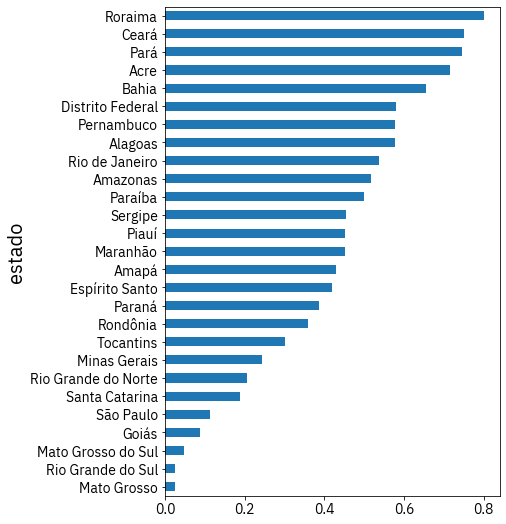

In [52]:
df_tmp = df_h[df_h['deactivated_proxy'] == False]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [53]:
len(df_h[df_h.has_uti_proxy == True]) / len(df_h)

0.4693131365891878

<AxesSubplot:ylabel='estado'>

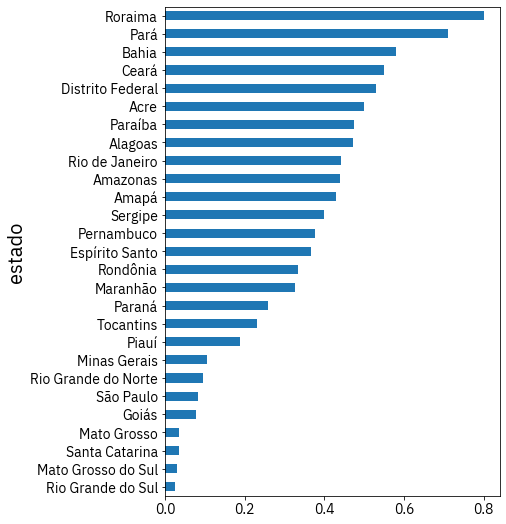

In [54]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

In [55]:
df_h.groupby(['tpGestao',]).size()

tpGestao
D     485
E     704
M    2382
dtype: int64

In [56]:
df_h.groupby(['tpGestao', 'natJuridica']).size()

tpGestao  natJuridica
D         1               155
          2                29
          3               301
E         1               419
          2                40
          3               245
M         1              1235
          2               355
          3               791
          4                 1
dtype: int64

In [57]:
types_natJuridica = {
    '1': 'ADMINISTRAÇÃO PÚBLICA',
    '2': 'ENTIDADES EMPRESARIAIS',
    '3': 'ENTIDADES SEM FINS LUCRATIVOS',
    '4': 'PESSOAS FÍSICAS', # claramente um erro 
}

types_tpGestao = {
    'D': 'Dupla',
    'E': 'Estadual',
    'M': 'Municipal',
}

<AxesSubplot:ylabel='estado'>

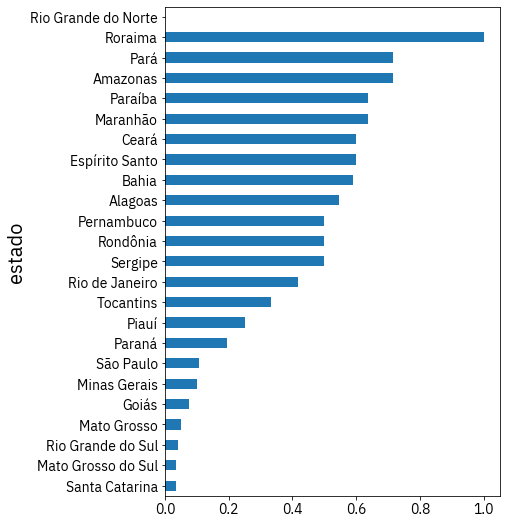

In [58]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao == 'M')]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado']).size() 
         / df_tmp.groupby(['estado']).size()
).sort_values().plot.barh(figsize=(6,9))

<AxesSubplot:ylabel='estado,tpGestao'>

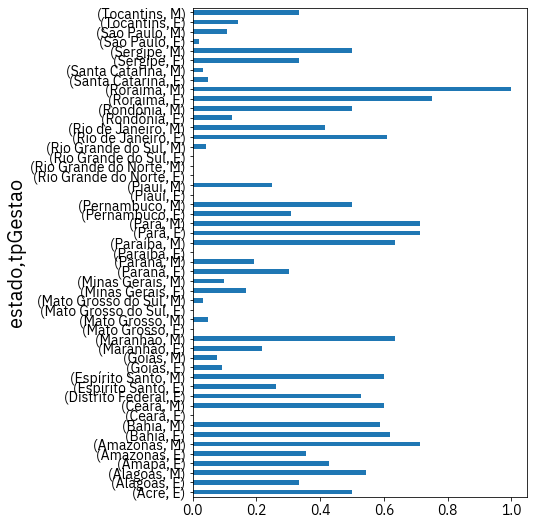

In [59]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
).plot.barh(figsize=(6,9))

<AxesSubplot:ylabel='tpGestao'>

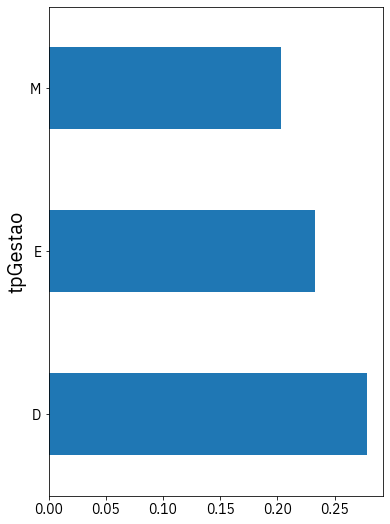

In [60]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E', 'D']))]

(df_tmp[df_tmp['updated_14d'] == False].groupby(['tpGestao']).size() 
         / df_tmp.groupby(['tpGestao']).size()
).plot.barh(figsize=(6,9))

In [61]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True) & (df_h.tpGestao.isin(['M', 'E']))]

df_tmp = (df_tmp[df_tmp['updated_14d'] == False].groupby(['estado', 'tpGestao']).size() 
         / df_tmp.groupby(['estado', 'tpGestao']).size()
)

df_tmp.reset_index().groupby(['tpGestao']).mean()

,0
tpGestao,
E,0.343140
M,0.398647


## Taxa de ocupação por estado

In [62]:
df_tmp = df_h[(df_h['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

by_state = df_tmp.groupby('estado').agg({
    '_id': 'count',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
})

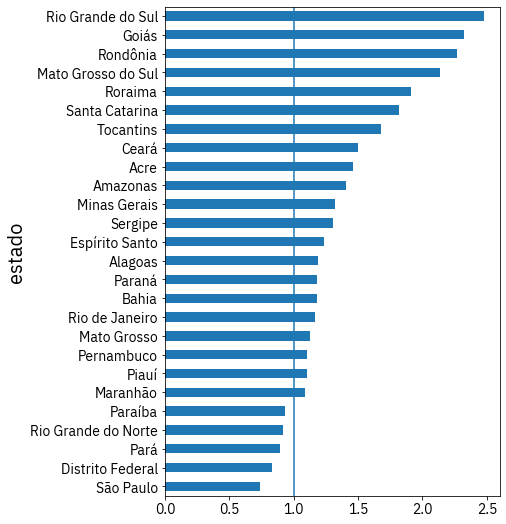

In [63]:
by_state['pct_occupied'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state[by_state['pct_occupied'] < 10]['pct_occupied'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

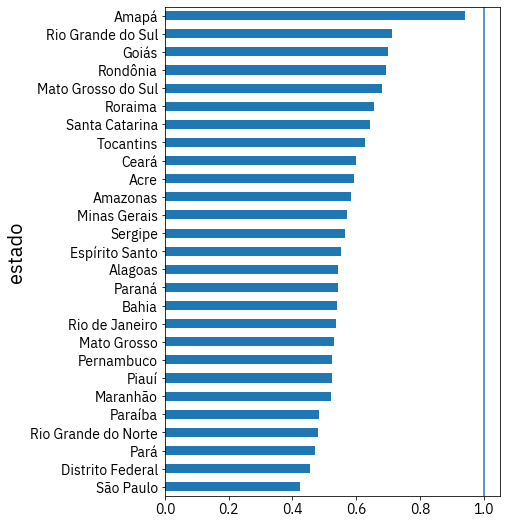

In [64]:
by_state['pct_occupied_alt'] = by_state['totalOcupUti'] / by_state['totalOfertaUtiAlt']
by_state[by_state['pct_occupied_alt'] < 10]['pct_occupied_alt'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

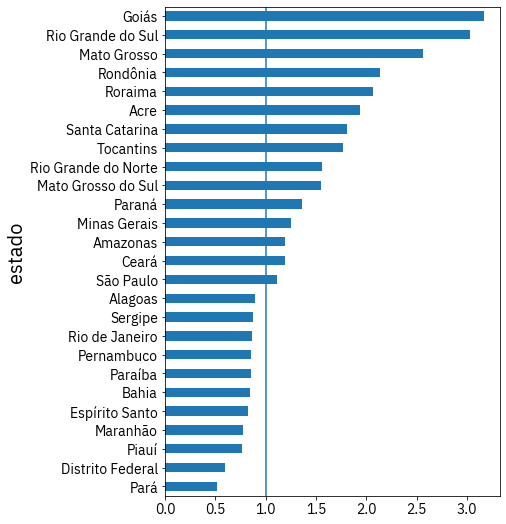

In [65]:
by_state['pct_occupied_srag'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state[by_state['pct_occupied_srag'] < 10]['pct_occupied_srag'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

In [66]:
by_state

,_id,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,updated_7d,updated_14d,updated_90d,pct_occupied,pct_occupied_alt,pct_occupied_srag
estado,,,,,,,,,,,,
Acre,2,76.0,187.0,111.0,50.0,97,1,1,2,1.460526,0.593583,1.940000
Alagoas,17,439.0,960.0,521.0,255.0,229,9,9,14,1.186788,0.542708,0.898039
Amapá,7,16.0,277.0,261.0,6.0,159,4,4,5,16.312500,0.942238,26.500000
Amazonas,25,496.0,1194.0,698.0,247.0,295,12,14,21,1.407258,0.584590,1.194332
Bahia,76,1881.0,4099.0,2218.0,1051.0,886,30,32,46,1.179160,0.541108,0.843007
Ceará,60,1536.0,3836.0,2300.0,858.0,1023,27,27,30,1.497396,0.599583,1.192308
Distrito Federal,17,687.0,1257.0,570.0,366.0,219,7,8,12,0.829694,0.453461,0.598361
Espírito Santo,30,1059.0,2363.0,1304.0,692.0,573,18,19,22,1.231350,0.551841,0.828035
Goiás,116,1451.0,4821.0,3370.0,471.0,1491,105,107,109,2.322536,0.699025,3.165605


## Leitos CNES

In [67]:
all_beds = []
for index, row in df_h[df_h['beds'].notna()].iterrows():
    beds = row['beds']
    for bed in beds:
        bed['cnes'] = row['cnes']
        all_beds.append(bed)

In [68]:
df_beds = pd.DataFrame(all_beds)
df_beds.head()

,dsAtributo,coLeito,dsLeito,qtExistente,qtSus,cnes
0,ESPEC - CIRURGICO,03,CIRURGIA GERAL,3,1,2249626
1,ESPEC - CIRURGICO,06,GINECOLOGIA,1,1,2249626
2,ESPEC - CLINICO,32,CARDIOLOGIA,2,1,2249626
3,ESPEC - CLINICO,33,CLINICA GERAL,23,10,2249626
4,OBSTETRICO,10,OBSTETRICIA CIRURGICA,1,1,2249626


In [69]:
df_beds['total_beds'] = df_beds['qtExistente'].astype(float)

In [70]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo']).total_beds.sum().sort_values(ascending=False))

dsLeito                                                       dsAtributo  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR    20263.0
UTI ADULTO - TIPO II                                          COMPLEMENTAR    15735.0
UTI NEONATAL - TIPO II                                        COMPLEMENTAR     4896.0
UTI ADULTO - TIPO III                                         COMPLEMENTAR     3540.0
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR     2336.0
UTI ADULTO - TIPO I                                           COMPLEMENTAR     1856.0
UTI NEONATAL - TIPO III                                       COMPLEMENTAR      882.0
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR      784.0
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR      609.0
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR      540.0
UTI NEONATAL - TIPO I                                         COM

### Leitos tipo UTI

In [71]:
df_beds['uti'] = np.where(df_beds.dsLeito.str[0:3] == 'UTI', np.where(df_beds.dsLeito.str.contains('NEONATAL|QUEIMADOS') == False, True, False), False)

In [72]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_beds[df_beds.dsLeito.str[0:3] == 'UTI'].groupby(['dsLeito', 'dsAtributo', 'uti']).size().sort_values(ascending=False))

dsLeito                                                       dsAtributo    uti  
UTI II ADULTO-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19      COMPLEMENTAR  True     1065
UTI ADULTO - TIPO II                                          COMPLEMENTAR  True      982
UTI NEONATAL - TIPO II                                        COMPLEMENTAR  False     433
UTI PEDIATRICA - TIPO II                                      COMPLEMENTAR  True      300
UTI ADULTO - TIPO I                                           COMPLEMENTAR  True      161
UTI ADULTO - TIPO III                                         COMPLEMENTAR  True      118
UTI II PEDIATRICA-SINDROME RESP. AGUDA GRAVE (SRAG)-COVID-19  COMPLEMENTAR  True       97
UTI PEDIATRICA - TIPO III                                     COMPLEMENTAR  True       71
UTI NEONATAL - TIPO III                                       COMPLEMENTAR  False      68
UTI CORONARIANA TIPO II - UCO TIPO II                         COMPLEMENTAR  True       58
UTI NEONATAL - TIP

In [73]:
cnes_uti = df_beds[df_beds['uti'] == True].groupby('cnes').agg({'total_beds': 'sum'})
cnes_uti.reset_index(inplace=True)
cnes_uti.rename(columns={'total_beds': 'uti_beds_via_cnes'}, inplace=True)
cnes_uti.head()

,cnes,uti_beds_via_cnes
0,0000396,10.0
1,0000418,70.0
2,0000426,123.0
3,0000434,143.0
4,0000477,98.0


In [74]:
df_hb = df_h.merge(cnes_uti, on='cnes', how='left')

In [75]:
df_hb.head()

,_index,_type,_id,_score,estado,estadoSigla,municipio,cnes,nomeCnes,dataNotificacaoOcupacao,...,nuCompDesab,dtCarga,dtAtualizacaoOrigem,dtAtualizacao,beds,deactivated,ts_run_cnes,error,deactivated_proxy,uti_beds_via_cnes
0,leito_ocupacao,_doc,2249626,1.0,Rio Grande do Sul,RS,Estação,2249626,HOSPITAL SANTO ANTONIO ESTACAO,2021-03-05 06:40:51+00:00,...,None,02/03/2021,17/03/2003,06/08/2019,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
1,leito_ocupacao,_doc,2338386,1.0,Goiás,GO,Goiânia,2338386,FUNDACAO BANCO DE OLHOS DE GOIAS,2021-03-05 11:21:37+00:00,...,None,01/03/2021,30/10/2001,05/11/2020,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
2,leito_ocupacao,_doc,2384035,1.0,Goiás,GO,Santa Rosa de Goiás,2384035,HOSPITAL MUNICIPAL DE SANTA ROSA DE GOIAS,2021-03-05 07:54:52+00:00,...,None,25/02/2021,24/06/2003,09/02/2021,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
3,leito_ocupacao,_doc,2519356,1.0,Goiás,GO,Goiânia,2519356,MATERNIDADE MODELO,2021-03-05 09:13:53+00:00,...,None,01/03/2021,12/03/2002,05/04/2019,"[{'dsAtributo': 'ESPEC - CIRURGICO', 'coLeito'...",False,2021-03-03T18:25:14.012835+00:00,False,False,NaN
4,leito_ocupacao,_doc,2664836,1.0,Goiás,go,Goiânia,2664836,NaN,2021-03-05 09:03:19+00:00,...,None,01/03/2021,08/04/2003,25/07/2019,[],False,2021-03-03T18:25:14.012835+00:00,False,False,NaN


In [76]:
df_hb.columns.values

array(['_index', '_type', '_id', '_score', 'estado', 'estadoSigla',
       'municipio', 'cnes', 'nomeCnes', 'dataNotificacaoOcupacao',
       'ofertaRespiradores', 'ofertaHospCli', 'ofertaHospUti',
       'ofertaSRAGCli', 'ofertaSRAGUti', 'ocupHospCli', 'ocupHospUti',
       'ocupSRAGCli', 'ocupSRAGUti', 'altas', 'obitos',
       'ocupacaoInformada', 'algumaOcupacaoInformada', 'ts_run',
       'totalOfertaCli', 'totalOfertaUti', 'totalOcupCli', 'totalOcupUti',
       'totalOfertaCliAlt', 'totalOfertaUtiAlt', 'has_uti_proxy',
       'updated_7d', 'updated_14d', 'updated_90d', 'id', 'noFantasia',
       'noEmpresarial', 'natJuridica', 'natJuridicaMant', 'cnpj',
       'tpPessoa', 'nvDependencia', 'nuAlvara', 'dtExpAlvara',
       'orgExpAlvara', 'dsTpUnidade', 'dsStpUnidade', 'noLogradouro',
       'nuEndereco', 'cep', 'regionalSaude', 'bairro', 'noComplemento',
       'municipio_cnes', 'noMunicipio', 'uf', 'tpGestao', 'nuTelefone',
       'tpSempreAberto', 'coMotivoDesab', 'dsMotivoDesa

In [77]:
df_hb['bed_diff'] = df_hb['totalOfertaUti'] - df_hb['uti_beds_via_cnes']
df_hb['bed_diff_alt'] = df_hb['totalOfertaUtiAlt'] - df_hb['uti_beds_via_cnes']

count    1534.000000
mean       -4.495437
std        18.082500
min      -178.000000
25%       -10.000000
50%        -1.000000
75%         0.000000
max       280.000000
Name: bed_diff, dtype: float64


<AxesSubplot:>

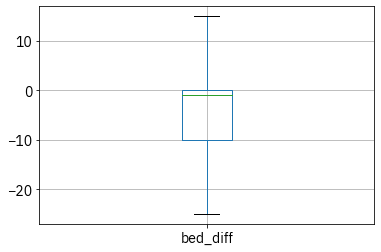

In [78]:
print(df_hb['bed_diff'].describe())
df_hb[['bed_diff']].boxplot(showfliers=False)

count    1534.000000
mean       25.641460
std        40.467964
min       -60.000000
25%         4.000000
50%        15.000000
75%        34.000000
max       435.000000
Name: bed_diff_alt, dtype: float64


<AxesSubplot:>

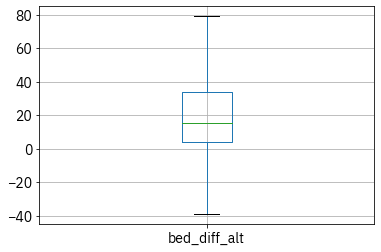

In [79]:
print(df_hb['bed_diff_alt'].describe())
df_hb[['bed_diff_alt']].boxplot(showfliers=False)

In [80]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]

by_state = df_tmp.groupby('estado').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
})

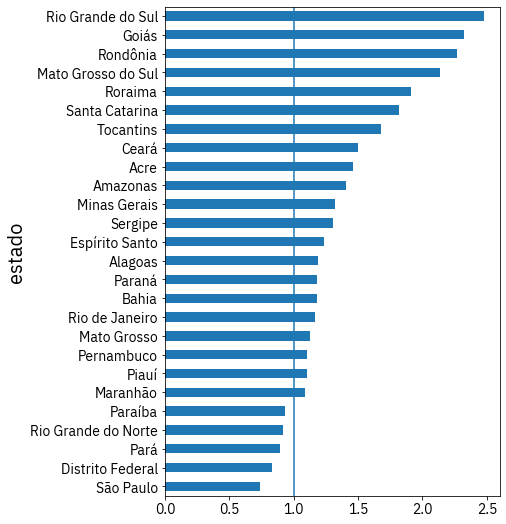

In [81]:
by_state['pct_occupied'] = by_state['totalOcupUti'] / by_state['totalOfertaUti']
by_state[by_state['pct_occupied'] < 10]['pct_occupied'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

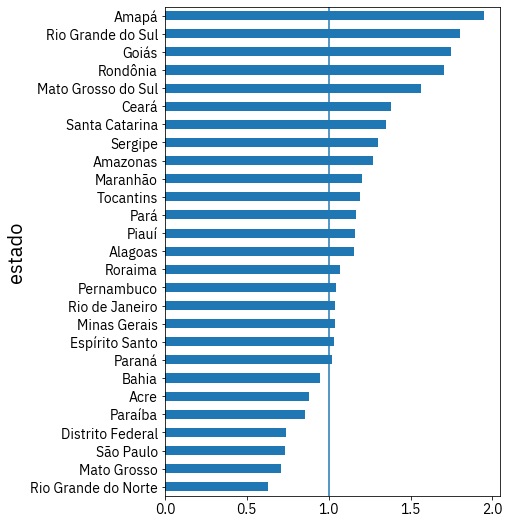

In [82]:
by_state['pct_occupied_cnes'] = by_state['totalOcupUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes'] < 10]['pct_occupied_cnes'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

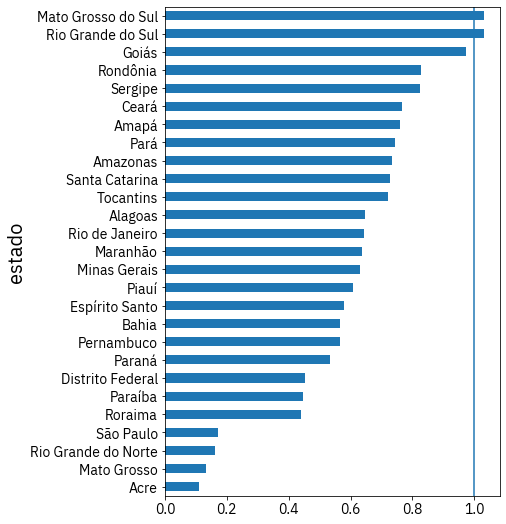

In [83]:
by_state['pct_occupied_cnes_hosp'] = by_state['ocupHospUti'] / by_state['uti_beds_via_cnes']
by_state[by_state['pct_occupied_cnes_hosp'] < 10]['pct_occupied_cnes_hosp'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

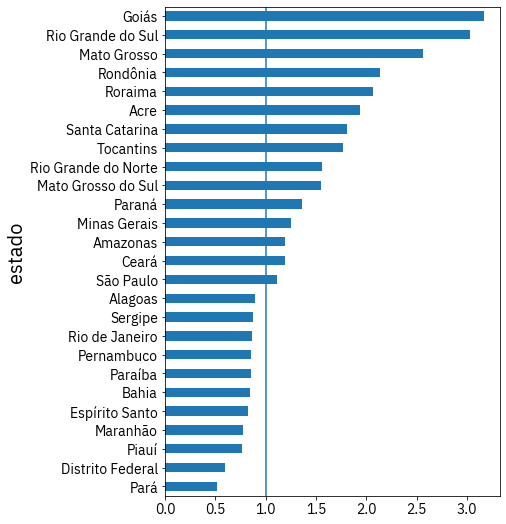

In [84]:
by_state['pct_occupied_srag'] = by_state['ocupSRAGUti'] / by_state['ofertaSRAGUti']
by_state[by_state['pct_occupied_srag'] < 10]['pct_occupied_srag'].sort_values().plot.barh(figsize=(6,9)).axvline(1)

In [85]:
by_state[10:]

,_id,uti_beds_via_cnes,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,ofertaHospUti,ocupHospUti,updated_7d,updated_14d,updated_90d,pct_occupied,pct_occupied_cnes,pct_occupied_cnes_hosp,pct_occupied_srag
estado,,,,,,,,,,,,,,,,
Mato Grosso,55,1064.0,672.0,1429.0,757.0,241.0,617,431.0,140.0,53,53,54,1.126488,0.711466,0.131579,2.560166
Mato Grosso do Sul,33,749.0,550.0,1723.0,1173.0,259.0,401,291.0,772.0,31,32,33,2.132727,1.566088,1.030708,1.548263
Minas Gerais,197,5295.0,4158.0,9662.0,5504.0,1729.0,2169,2429.0,3335.0,171,176,186,1.323713,1.039471,0.629839,1.254482
Paraná,81,2748.0,2381.0,5192.0,2811.0,989.0,1349,1392.0,1462.0,55,60,70,1.180596,1.022926,0.532023,1.364004
Paraíba,19,535.0,491.0,950.0,459.0,259.0,220,232.0,239.0,7,10,11,0.934827,0.857944,0.446729,0.849421
Pará,31,676.0,882.0,1669.0,787.0,548.0,284,334.0,503.0,6,9,12,0.892290,1.164201,0.744083,0.518248
Pernambuco,53,1887.0,1794.0,3771.0,1977.0,1067.0,911,727.0,1066.0,30,33,41,1.102007,1.047695,0.564918,0.853796
Piauí,16,353.0,372.0,781.0,409.0,253.0,194,119.0,215.0,11,13,15,1.099462,1.158640,0.609065,0.766798
Rio Grande do Norte,42,834.0,573.0,1100.0,527.0,250.0,391,323.0,136.0,38,38,39,0.919721,0.631894,0.163070,1.564000


CREATE EXTERNAL TABLE IF NOT EXISTS datalake_medidasp.leitos (
  hits:array<struct<
    `_index`:string,
    `_type`:string,
    `_id`:string,
    `_score`:string,
    `_source.estado`:string,
    `_source.estadosigla`:string,
    `_source.municipio`:string,
    `_source.cnes`:string,
    `_source.nomecnes`:string,
    `_source.datanotificacaoocupacao`:string,
    `_source.ofertarespiradores`:string,
    `_source.ofertahospcli`:string,
    `_source.ofertahosputi`:string,
    `_source.ofertasragcli`:string,
    `_source.ofertasraguti`:string,
    `_source.ocuphospcli`:string,
    `_source.ocuphosputi`:string,
    `_source.ocupsragcli`:string,
    `_source.ocupsraguti`:string,
    `_source.altas`:string,
    `_source.obitos`:string,
    `_source.ocupacaoinformada`:string,
    `_source.algumaocupacaoinformada`:string>> 
)
ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
WITH SERDEPROPERTIES (
  'serialization.format' = '1'
) LOCATION 's3://medidasp/leitos/'
TBLPROPERTIES ('has_encrypted_data'='false');

## Comparação com Painéis Estaduais

In [86]:
df_ses = pd.read_csv('ses/dados_secretarias.csv', sep=',')

In [87]:
df_ses.head()

,estado,ts_consulta,data_autalizacao,hora_atualizacao,obs,fonte,fonte_url,uti_total_oferta,uti_total_bloquada,uti_total_ocupada,...,uti_covid_total_oferta,uti_covid_total_ocupada,uti_covid_total_bloqueada,pct_uti_covid_total_ocupada,uti_covid_adulto_oferta,uti_covid_adulto_ocupada,pct_uti_covid_adulto_ocupada,uti_covid_pediatrica_oferta,uti_covid_pediatrica_ocupada,pct_uti_covid_pediatrica_ocupada
0,MT,2021-03-10 10:52:00,2021-03-09,17:37:39,NaN,"Painel Covid-19, Secretaria do Estado de Saúde...",http://www.saude.mt.gov.br/painelcovidmt2/,498.0,4.0,475.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MA,2021-03-10 11:01:00,NaN,NaN,O painel é inconsistente internamente: em um l...,"Painel Coronavírus, Secretaria de Saúde",https://painel-covid19.saude.ma.gov.br/casos,NaN,NaN,NaN,...,410.0,350.0,NaN,0.853659,NaN,NaN,NaN,NaN,NaN,NaN
2,BA,2021-03-10 11:06:00,2021-03-09,19:22:00,NaN,Painel SEI Covid,https://infovis.sei.ba.gov.br/covid19/,NaN,NaN,NaN,...,1211.0,1051.0,NaN,0.867878,NaN,NaN,NaN,NaN,NaN,NaN
3,PA,2021-03-10 11:11:00,NaN,NaN,Leitos são “Somente gestão do Governo do Estad...,NaN,https://www.covid-19.pa.gov.br/#/,NaN,NaN,NaN,...,495.0,377.0,NaN,0.761616,487.0,373.0,0.765914,8.0,4.0,0.5
4,PB,2021-03-10 11:16:00,2021-03-10,11:00:13,NaN,Gestão de Leitos Covid-19 Paraíba,https://superset.plataformatarget.com.br/super...,NaN,NaN,NaN,...,428.0,344.0,NaN,0.803738,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
df_ses['data_consulta'] = df_ses['ts_consulta'].str[:10]
df_ses['data'] = np.where(df_ses.data_autalizacao.notna(), df_ses.data_autalizacao, df_ses.data_consulta)

In [89]:
# every row must have at least one of these data
print('estados sem dados:', df_ses[(df_ses.uti_total_oferta.isna()) & (df_ses.uti_covid_total_oferta.isna())].estado.tolist())

estados sem dados: ['RJ']


In [90]:
df_tmp.estadoSigla.str.upper().unique()

array(['PR', 'AM', 'MG', 'RJ', 'SC', 'SE', 'PE', 'BA', 'PA', 'ES', 'SP',
       'RS', 'PB', 'RR', 'CE', 'MA', 'RO', 'MT', 'AL', 'DF', 'RN', 'GO',
       'PI', 'MS', 'TO', 'AC', 'AP'], dtype=object)

In [91]:
df_tmp = df_hb[(df_hb['deactivated_proxy'] == False) & (df_h.has_uti_proxy == True)]
df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()

by_state = df_tmp.groupby('estadoSigla').agg({
    '_id': 'count',
    'uti_beds_via_cnes': 'sum',
    'totalOfertaUti': 'sum',
    'totalOfertaUtiAlt': 'sum',
    'totalOcupUti': 'sum',
    'ofertaSRAGUti': 'sum',
    'ocupSRAGUti': 'sum',
    'ofertaHospUti': 'sum',
    'ocupHospUti': 'sum',
    'updated_7d': 'sum',
    'updated_14d': 'sum',
    'updated_90d': 'sum',
}).reset_index()

<ipython-input-91-53876912aefd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['estadoSigla'] = df_tmp['estadoSigla'].str.upper()


In [92]:
by_state_ses = by_state.merge(df_ses, left_on='estadoSigla', right_on='estado', how='left')

In [93]:
by_state_ses.head()

,estadoSigla,_id,uti_beds_via_cnes,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,ofertaHospUti,ocupHospUti,...,uti_covid_total_bloqueada,pct_uti_covid_total_ocupada,uti_covid_adulto_oferta,uti_covid_adulto_ocupada,pct_uti_covid_adulto_ocupada,uti_covid_pediatrica_oferta,uti_covid_pediatrica_ocupada,pct_uti_covid_pediatrica_ocupada,data_consulta,data
0,AC,2,126.0,76.0,187.0,111.0,50.0,97,26.0,14.0,...,NaN,1.027027,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-02-28
1,AL,17,452.0,439.0,960.0,521.0,255.0,229,184.0,292.0,...,NaN,0.751613,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-10
2,AM,25,548.0,496.0,1194.0,698.0,247.0,295,249.0,403.0,...,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09
3,AP,7,134.0,16.0,277.0,261.0,6.0,159,10.0,102.0,...,NaN,0.830645,119.0,100.0,0.840336,5.0,3.0,0.6,2021-03-10,2021-03-10
4,BA,76,2349.0,1881.0,4099.0,2218.0,1051.0,886,830.0,1332.0,...,NaN,0.867878,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-10,2021-03-09


In [94]:
by_state_ses['diff_uti_total_oferta'] = (by_state_ses['totalOfertaUti'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_total_ocup'] = (by_state_ses['totalOcupUti'] / by_state_ses['uti_total_ocupada']) - 1
by_state_ses['diff_uti_total_oferta_alt'] = (by_state_ses['totalOfertaUtiAlt'] / by_state_ses['uti_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_oferta'] = (by_state_ses['ofertaSRAGUti'] / by_state_ses['uti_covid_total_oferta']) - 1
by_state_ses['diff_uti_covid_total_ocup'] = (by_state_ses['ocupSRAGUti'] / by_state_ses['uti_covid_total_ocupada']) - 1

In [95]:
by_state_ses.head()

,estadoSigla,_id,uti_beds_via_cnes,totalOfertaUti,totalOfertaUtiAlt,totalOcupUti,ofertaSRAGUti,ocupSRAGUti,ofertaHospUti,ocupHospUti,...,uti_covid_pediatrica_oferta,uti_covid_pediatrica_ocupada,pct_uti_covid_pediatrica_ocupada,data_consulta,data,diff_uti_total_oferta,diff_uti_total_ocup,diff_uti_total_oferta_alt,diff_uti_covid_total_oferta,diff_uti_covid_total_ocup
0,AC,2,126.0,76.0,187.0,111.0,50.0,97,26.0,14.0,...,NaN,NaN,NaN,2021-03-10,2021-02-28,NaN,NaN,NaN,-0.549550,-0.149123
1,AL,17,452.0,439.0,960.0,521.0,255.0,229,184.0,292.0,...,NaN,NaN,NaN,2021-03-10,2021-03-10,NaN,NaN,NaN,-0.177419,-0.017167
2,AM,25,548.0,496.0,1194.0,698.0,247.0,295,249.0,403.0,...,NaN,NaN,NaN,2021-03-10,2021-03-09,-0.401689,0.041791,0.440290,-0.521318,-0.313953
3,AP,7,134.0,16.0,277.0,261.0,6.0,159,10.0,102.0,...,5.0,3.0,0.6,2021-03-10,2021-03-10,-0.934426,0.631250,0.135246,-0.951613,0.543689
4,BA,76,2349.0,1881.0,4099.0,2218.0,1051.0,886,830.0,1332.0,...,NaN,NaN,NaN,2021-03-10,2021-03-09,NaN,NaN,NaN,-0.132122,-0.156993


In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(by_state_ses[by_state_ses.estado == 'BA'].iloc[0])

estadoSigla                                                             BA
_id                                                                     76
uti_beds_via_cnes                                                     2349
totalOfertaUti                                                        1881
totalOfertaUtiAlt                                                     4099
totalOcupUti                                                          2218
ofertaSRAGUti                                                         1051
ocupSRAGUti                                                            886
ofertaHospUti                                                          830
ocupHospUti                                                           1332
updated_7d                                                              30
updated_14d                                                             32
updated_90d                                                             46
estado                   

In [97]:
cols = [
  'estadoSigla',
  'diff_uti_total_oferta',
  'diff_uti_total_ocup',
#   'diff_uti_total_oferta_alt',
  'diff_uti_covid_total_oferta',
  'diff_uti_covid_total_ocup',
]

by_state_ses[cols]

,estadoSigla,diff_uti_total_oferta,diff_uti_total_ocup,diff_uti_covid_total_oferta,diff_uti_covid_total_ocup
0,AC,NaN,NaN,-0.549550,-0.149123
1,AL,NaN,NaN,-0.177419,-0.017167
2,AM,-0.401689,0.041791,-0.521318,-0.313953
3,AP,-0.934426,0.631250,-0.951613,0.543689
4,BA,NaN,NaN,-0.132122,-0.156993
5,CE,0.488372,1.252693,NaN,NaN
6,DF,1.008772,1.134831,NaN,NaN
7,ES,NaN,NaN,-0.044199,-0.013769
8,GO,0.950269,3.977843,0.103044,2.681481
9,MA,NaN,NaN,0.158537,0.057143


### TODO

Adicionar notas:
- RJ está sem dados
- SP também; dados são de notícias
- AC está (muito) desatualizado?

[Text(0, 0.5, 'ES'),
 Text(0, 1.5, 'PE'),
 Text(0, 2.5, 'SP'),
 Text(0, 3.5, 'AL'),
 Text(0, 4.5, 'MA'),
 Text(0, 5.5, 'PI'),
 Text(0, 6.5, 'BA'),
 Text(0, 7.5, 'PA'),
 Text(0, 8.5, 'PR'),
 Text(0, 9.5, 'RN'),
 Text(0, 10.5, 'AM'),
 Text(0, 11.5, 'MG'),
 Text(0, 12.5, 'SC'),
 Text(0, 13.5, 'AC'),
 Text(0, 14.5, 'PB'),
 Text(0, 15.5, 'RO'),
 Text(0, 16.5, 'TO'),
 Text(0, 17.5, 'MT'),
 Text(0, 18.5, 'RS'),
 Text(0, 19.5, 'MS'),
 Text(0, 20.5, 'SE'),
 Text(0, 21.5, 'RR'),
 Text(0, 22.5, 'AP'),
 Text(0, 23.5, 'CE'),
 Text(0, 24.5, 'DF'),
 Text(0, 25.5, 'GO'),
 Text(0, 26.5, 'RJ')]

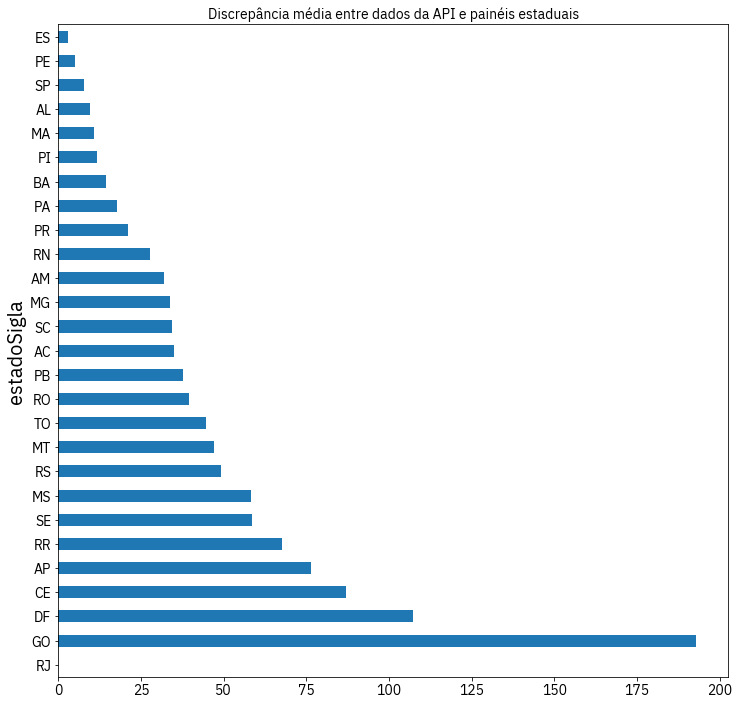

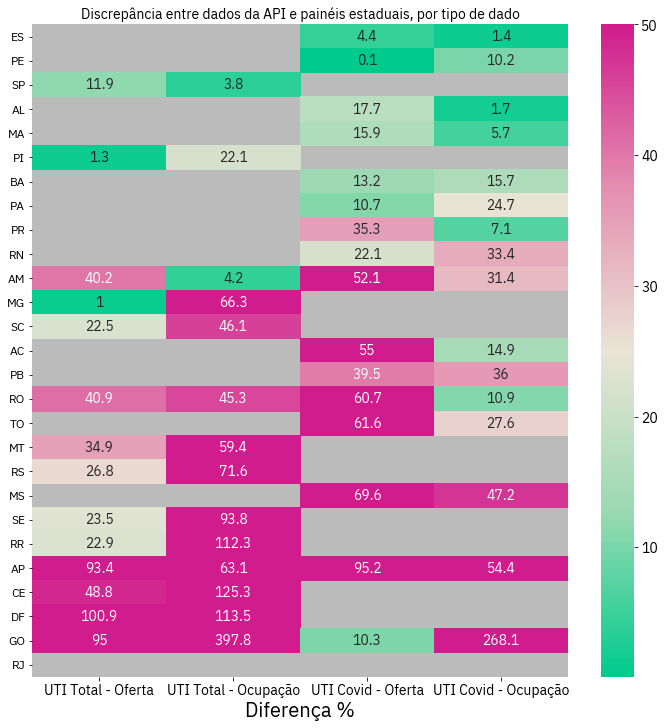

In [103]:
df_tmp = by_state_ses[cols].set_index('estadoSigla')
df_tmp = abs(df_tmp)
df_tmp = round(df_tmp * 100, 1)

fig_bar, ax_bar = plt.subplots(figsize=(12,12))
df_mean = df_tmp.T.mean().sort_values(ascending=True)
df_mean.plot.barh(ax=ax_bar).invert_yaxis()
ax_bar.set_title('Discrepância média entre dados da API e painéis estaduais')

# reorder to match df_mean order
df_heatmap = df_tmp.reindex(index=df_mean.reset_index()['estadoSigla'])
# plot
# color_scale = 'PiYG_r'
# color_scale = 'RdYlGn_r'
color_scale = OK_COLOR_SCALE_DIVERGING
xticklabels = [
    'UTI Total - Oferta',
    'UTI Total - Ocupação',
    'UTI Covid - Oferta',
    'UTI Covid - Ocupação',
]
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df_heatmap, annot=True, ax=ax, cmap=color_scale, fmt='g', vmax=50, xticklabels=xticklabels)
ax.set_title('Discrepância entre dados da API e painéis estaduais, por tipo de dado')
ax.set_ylabel('')
ax.set_xlabel('Diferença %')
ax.set_facecolor('#bbbbbb')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)